In [2]:
import sys
sys.path.append('../../src')
from config import Paths

In [3]:
import pandas as pd

df = pd.read_csv(Paths.testnino1_classification_task, usecols=['id', 'Lang', 'Data', 'Link', 'Titolo', 'Testo', 'Stato Workflow'])

df['Data'] = pd.to_datetime(df['Data'])

target_column = 'Stato Workflow'

# remove rows not validated by the analyst
df = df[df[target_column] != 'N']

df = df[df['Lang'] == 'EN']

print(df.dtypes)
print(df.shape)

id                         int64
Data              datetime64[ns]
Link                      object
Titolo                    object
Testo                     object
Lang                      object
Stato Workflow            object
dtype: object
(2349, 7)


In [4]:
df.head()

,id,Data,Link,Titolo,Testo,Lang,Stato Workflow
147,1183650630,2023-10-01,http://www.instagram.com/p/Cx3WMtZt7TU,Hotel Muchele - hotel_muchele (5040069464),Hotel Muchele - hotel_muchele (5040069464) 42 ...,EN,Y
148,1183650631,2023-10-02,http://www.instagram.com/p/Cx31kqFJtS0,AdrianaValle PatriciaCarvalho - migsarquitetur...,AdrianaValle PatriciaCarvalho - migsarquitetur...,EN,Y
156,1183875522,2023-10-02,http://www.instagram.com/p/Cx4e0U-LL_u,"Florist Class, Event Decorator - flos.cotidie ...","Florist Class, Event Decorator - flos.cotidie ...",EN,D
157,1183875524,2023-10-02,http://www.instagram.com/p/Cx4jjjOou8l,Deloudis - deloudis_ (2998454195),Deloudis - deloudis_ (2998454195) Wiggle wiggl...,EN,Y
167,1183917193,2023-10-02,http://www.instagram.com/p/Cx4aYb6Ir1i,Karan Desai - karandesai_a.d (307496294),Karan Desai - karandesai_a.d (307496294) Proje...,EN,Y


Stato Workflow
D    1272
Y    1077
Name: count, dtype: int64


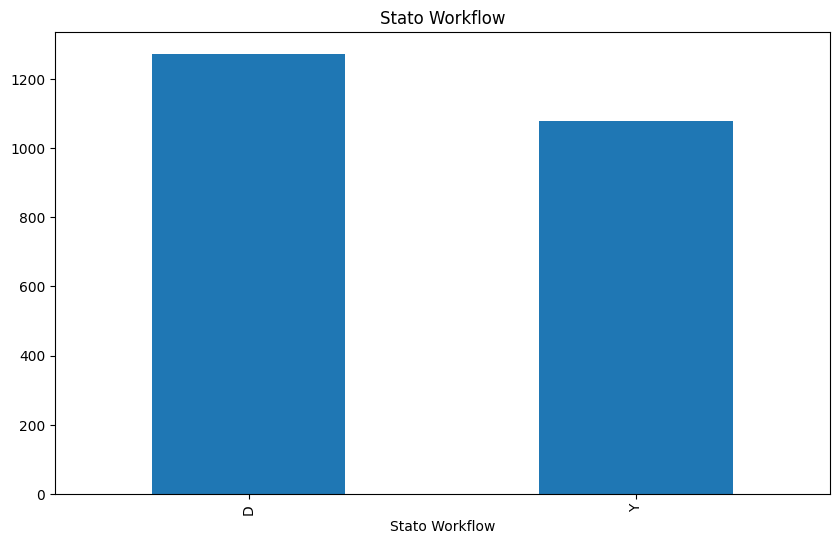

In [5]:
import matplotlib.pyplot as plt

column_counts = df[target_column].value_counts()
print(column_counts)
column_counts.plot(kind='bar', figsize=(10, 6))
plt.title(target_column)
plt.show()


In [ ]:
for model_name, score in results.items():
    print(model_name)
    print(f"{score.mean():.2f} (+/- {score.std() * 2:.2f})")
    print()


In [ ]:
import time
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import FunctionTransformer, Pipeline
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score


classifiers = [
    GradientBoostingClassifier(random_state=42),
    KNeighborsClassifier(n_jobs=-1),
    SVC(random_state=42),
    GaussianProcessClassifier(random_state=42),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(n_jobs=-1, random_state=42),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(random_state=42),
    QuadraticDiscriminantAnalysis(),
    GaussianNB(),
]

N = 10

# Assume df is your DataFrame and 'class' is the column with class labels
class_Y = df[df['class'] == 'Y']
class_D = df[df['class'] == 'D']

# Sample N instances from each class
sampled_Y = class_Y.sample(N/2, random_state=42)
sampled_D = class_D.sample(N/2, random_state=42)

# Concatenate the results
balanced_df = pd.concat([sampled_Y, sampled_D])

# Now balanced_df contains an equal number of instances from class A and class B

datasets = {
    10 :      train_test_split(df['Testo'], df['Stato Workflow'], random_state=42, train_size=10),
    50 :      train_test_split(df['Testo'], df['Stato Workflow'], random_state=42, train_size=50),
    100 :     train_test_split(df['Testo'], df['Stato Workflow'], random_state=42, train_size=100),
    200 :     train_test_split(df['Testo'], df['Stato Workflow'], random_state=42, train_size=200),
    500 :     train_test_split(df['Testo'], df['Stato Workflow'], random_state=42, train_size=500),
    750 :     train_test_split(df['Testo'], df['Stato Workflow'], random_state=42, train_size=750),
    1_000 :   train_test_split(df['Testo'], df['Stato Workflow'], random_state=42, train_size=1_000),
}

cms = {}
accuracies = {}
fit_times = {}
prediction_times = {}


# Create a FunctionTransformer to convert sparse matrices to dense ones
to_dense = FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)

# Create pipelines
for clf in classifiers:

    # Create a separate pipeline for the GaussianClassifiers
    if isinstance(clf, GaussianProcessClassifier) or isinstance(clf, GaussianNB) or isinstance(clf, QuadraticDiscriminantAnalysis):
        pipeline = Pipeline(
            [
                ("vect", CountVectorizer()),
                ("tfidf", TfidfTransformer()),
                ("to_dense", to_dense),
                ("clf", clf),
            ]
        )
    else:
        pipeline = Pipeline(
            [
                ("vect", CountVectorizer()),
                ("tfidf", TfidfTransformer()),
                ("clf", clf),
            ]
        )
        
    for key in datasets.keys():
        model_name = f"{key}-{clf.__class__.__name__}-{clf.get_params()}"
        X_train = datasets[key][0]
        X_test = datasets[key][1]
        y_train = datasets[key][2]
        y_test = datasets[key][3]

        print("***************************************************************")
        print(f"Evaluating model {model_name}...")
        try:
            
            start_time = time.time()
            pipeline.fit(X_train, y_train)
            fit_time = time.time() - start_time
            fit_times[model_name] = fit_time

            start_time = time.time()
            y_pred = pipeline.predict(X_test)
            prediction_time = time.time() - start_time
            prediction_times[model_name] = prediction_time
            
            cm = confusion_matrix(y_test, y_pred)
            cms[model_name] = cm
            
            accuracy = accuracy_score(y_test, y_pred)
            accuracies[model_name] = accuracy
            
            print(f"{model_name}")
            print(f"{accuracy:.2f}")
            print("***************************************************************\n\n")
        except Exception as e:
            print(f"An error occurred: {str(e)}")
            
import pickle

# Save the dictionaries to a file
with open('results_EN.pkl', 'wb') as file:
    pickle.dump(cms, file)
    pickle.dump(accuracies, file)
    pickle.dump(fit_times, file)
    pickle.dump(prediction_times, file)



In [13]:
import pickle

# Save the dictionaries to a file
with open('results.pkl', 'wb') as file:
    pickle.dump(cms, file)
    pickle.dump(accuracies, file)
    pickle.dump(fit_times, file)
    pickle.dump(prediction_times, file)

# # Load the dictionaries from the file
# with open('results.pkl', 'rb') as file:
#     cms = pickle.load(file)
#     accuracies = pickle.load(file)
#     fit_times = pickle.load(file)
#     prediction_times = pickle.load(file)
    



In [ ]:
for model_name, accuracy in accuracies.items():
    print(model_name)
    print(f"{accuracy:.2f}")
    print(f"{cms[model_name]}")
    print(f"fit_time: {fit_times[model_name]:.2f}")
    print(f"prediction_time: {prediction_times[model_name]:.2f}")
    print()
